/Users/jure/PhD/coding/tracking/cloudtracker/ct_venv/lib/python3.9/site-packages/numpy/lib/stride_tricks.py:538: UserWarning: Warning: converting a masked element to nan.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]


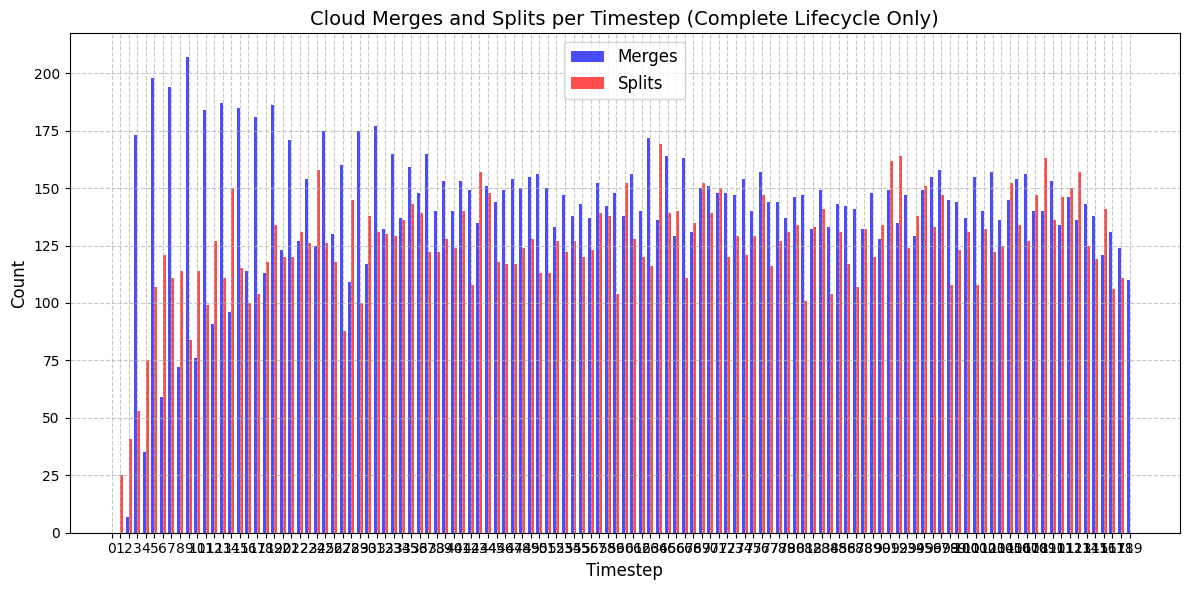

Total merge events (complete lifecycle clouds): 16823
Total split events (complete lifecycle clouds): 14767


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np

# Load your data
nc_file = '../output_archive/cloud_results_120mins.nc'
dataset = Dataset(nc_file, 'r')

# Load valid track information
valid_tracks = dataset.variables['valid_track'][:]
full_lifecycle_indices = np.where(valid_tracks == 1)[0]

# Load merge and split variables
merges_count = dataset.variables['merges_count'][:]
splits_count = dataset.variables['splits_count'][:]
time_steps = dataset.variables['merges_count'].shape[1]  # Number of timesteps

# Filter for valid clouds (full lifecycle)
filtered_merges_count = merges_count[full_lifecycle_indices, :]
filtered_splits_count = splits_count[full_lifecycle_indices, :]

# Calculate total merges and splits per timestep (only for valid clouds)
total_merges_per_timestep = np.nansum(filtered_merges_count > 0, axis=0)
total_splits_per_timestep = np.nansum(filtered_splits_count > 0, axis=0)

# Create the plot
plt.figure(figsize=(12, 6))
time_indices = np.arange(time_steps)
bar_width = 0.35

plt.bar(time_indices - bar_width/2, total_merges_per_timestep, 
        width=bar_width, label='Merges', color='blue', alpha=0.7)
plt.bar(time_indices + bar_width/2, total_splits_per_timestep, 
        width=bar_width, label='Splits', color='red', alpha=0.7)

plt.xlabel('Timestep', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Cloud Merges and Splits per Timestep (Complete Lifecycle Only)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(time_indices)
plt.tight_layout()
plt.show()

# Print summary statistics
total_merges = np.nansum(filtered_merges_count > 0)
total_splits = np.nansum(filtered_splits_count > 0)
print(f"Total merge events (complete lifecycle clouds): {total_merges}")
print(f"Total split events (complete lifecycle clouds): {total_splits}")

dataset.close()

Found 2617 valid clouds with complete lifecycles for plotting


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_9292/2675382754.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', len(active_clouds))


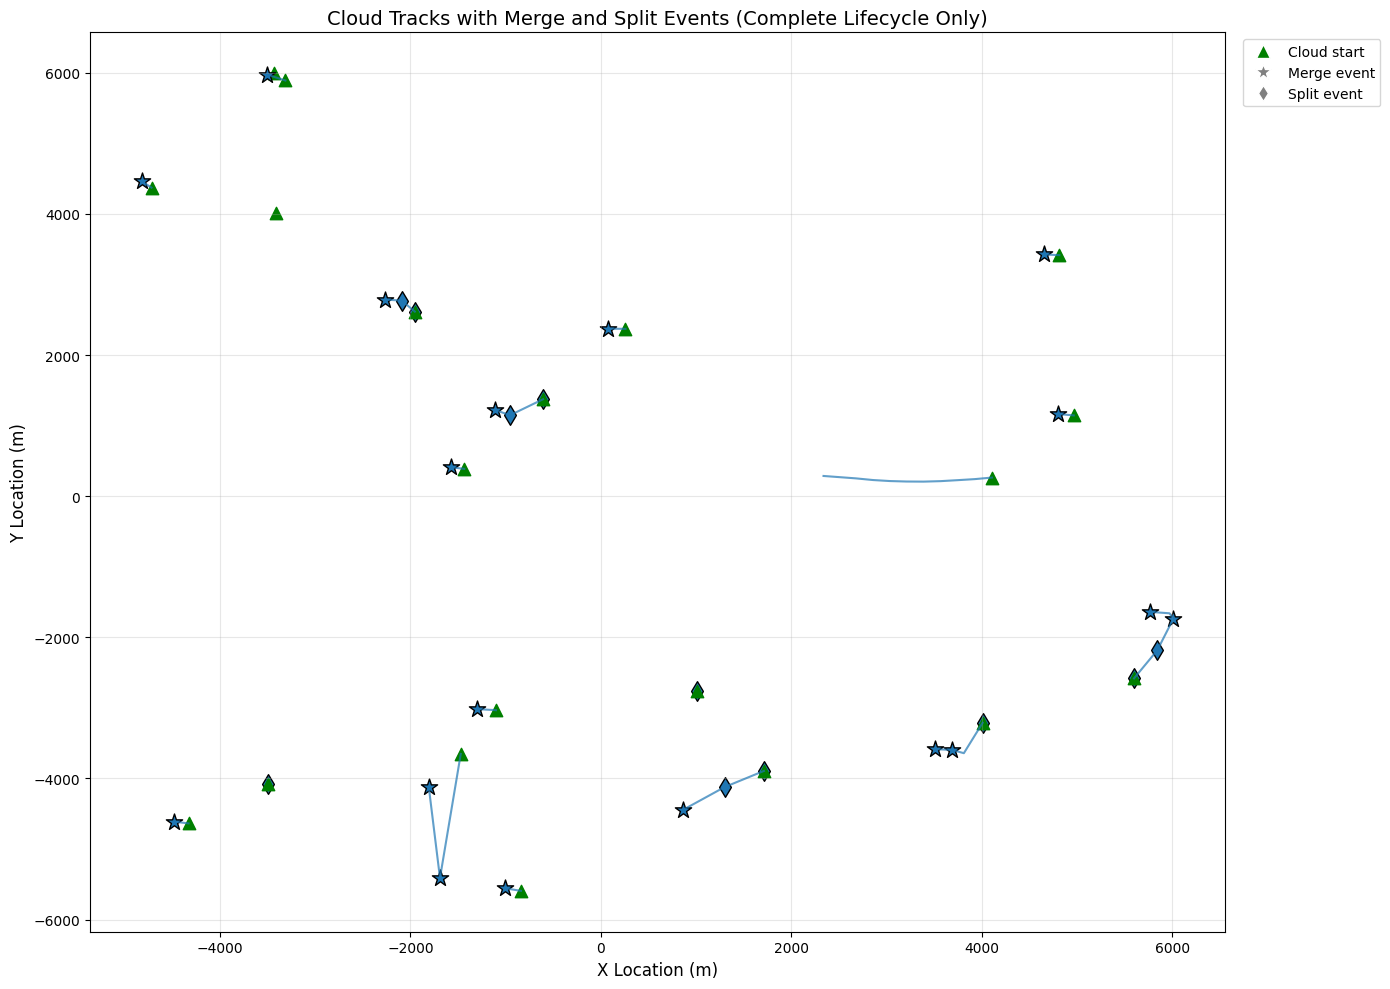

In [2]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import matplotlib.cm as cm

# Load your data
nc_file = '../cloud_results.nc'
dataset = Dataset(nc_file, 'r')

# Load all necessary variables
valid_tracks = dataset.variables['valid_track'][:]
x_centers = dataset.variables['location_x'][:]
y_centers = dataset.variables['location_y'][:]
merges_count = dataset.variables['merges_count'][:]
splits_count = dataset.variables['splits_count'][:]
merged_into = dataset.variables['merged_into'][:]
split_from = dataset.variables['split_from'][:]

# Filter for valid clouds (complete lifecycle only)
full_lifecycle_mask = (valid_tracks == 1)
valid_cloud_indices = (np.any(~np.isnan(x_centers), axis=1) & 
                       np.any(~np.isnan(y_centers), axis=1) & 
                       full_lifecycle_mask)
active_clouds = np.where(valid_cloud_indices)[0]

# Print how many clouds we're plotting
print(f"Found {len(active_clouds)} valid clouds with complete lifecycles for plotting")

# Plot setup
plt.figure(figsize=(14, 10))
colors = cm.get_cmap('tab10', len(active_clouds))

# Create a plot for a subset of clouds (adjust as needed for readability)
max_clouds_to_plot = min(20, len(active_clouds))
selected_clouds = active_clouds[:max_clouds_to_plot]

# Plot each cloud track
for i, cloud_idx in enumerate(selected_clouds):
    # Get valid timesteps for this cloud
    valid_idx = ~np.isnan(x_centers[cloud_idx, :]) & ~np.isnan(y_centers[cloud_idx, :])
    
    if np.any(valid_idx):
        # Plot the cloud track
        plt.plot(x_centers[cloud_idx, valid_idx], y_centers[cloud_idx, valid_idx], '-', 
                color=colors(i), linewidth=1.5, alpha=0.7,
                label=f'Cloud {cloud_idx}')
        
        # Mark timesteps with merge events
        merge_timesteps = np.where(valid_idx & (merges_count[cloud_idx, :] > 0))[0]
        if len(merge_timesteps) > 0:
            plt.scatter(x_centers[cloud_idx, merge_timesteps], 
                       y_centers[cloud_idx, merge_timesteps],
                       marker='*', s=150, color=colors(i), edgecolor='black', 
                       label=f'Cloud {cloud_idx} merges' if i == 0 else '')
        
        # Mark timesteps with split events
        split_timesteps = np.where(valid_idx & (splits_count[cloud_idx, :] > 0))[0]
        if len(split_timesteps) > 0:
            plt.scatter(x_centers[cloud_idx, split_timesteps], 
                       y_centers[cloud_idx, split_timesteps],
                       marker='d', s=100, color=colors(i), edgecolor='black',
                       label=f'Cloud {cloud_idx} splits' if i == 0 else '')
        
        # Mark the start of each cloud track
        start_idx = np.where(valid_idx)[0][0]
        plt.scatter(x_centers[cloud_idx, start_idx], y_centers[cloud_idx, start_idx], 
                   marker='^', s=80, color='green', 
                   label='Cloud start' if i == 0 else '')

# Add labels and legend with custom handles for merge/split events
plt.xlabel('X Location (m)', fontsize=12)
plt.ylabel('Y Location (m)', fontsize=12)
plt.title('Cloud Tracks with Merge and Split Events (Complete Lifecycle Only)', fontsize=14)
plt.grid(True, alpha=0.3)

# Create custom legend entries for merge and split markers
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=10, label='Cloud start'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', markersize=12, label='Merge event'),
    Line2D([0], [0], marker='d', color='w', markerfacecolor='gray', markersize=8, label='Split event')
]

# Add the legend
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=10)
plt.tight_layout()
plt.show()

dataset.close()

Found 99610 clouds with complete lifecycles
Found 1885 clouds with merges/splits
Top 5 most interactive clouds:
  Cloud 126: -- interactions
  Cloud 161: -- interactions
  Cloud 248: -- interactions
  Cloud 253: -- interactions
  Cloud 277: -- interactions
Limiting visualization to 30 most connected clouds
Added 157 merge edges and 78 split edges
Network has 216 nodes and 234 edges
Calculating graph layout...
Using spectral_layout for better performance with large graphs...
Drawing network graph...
Rendering final plot...


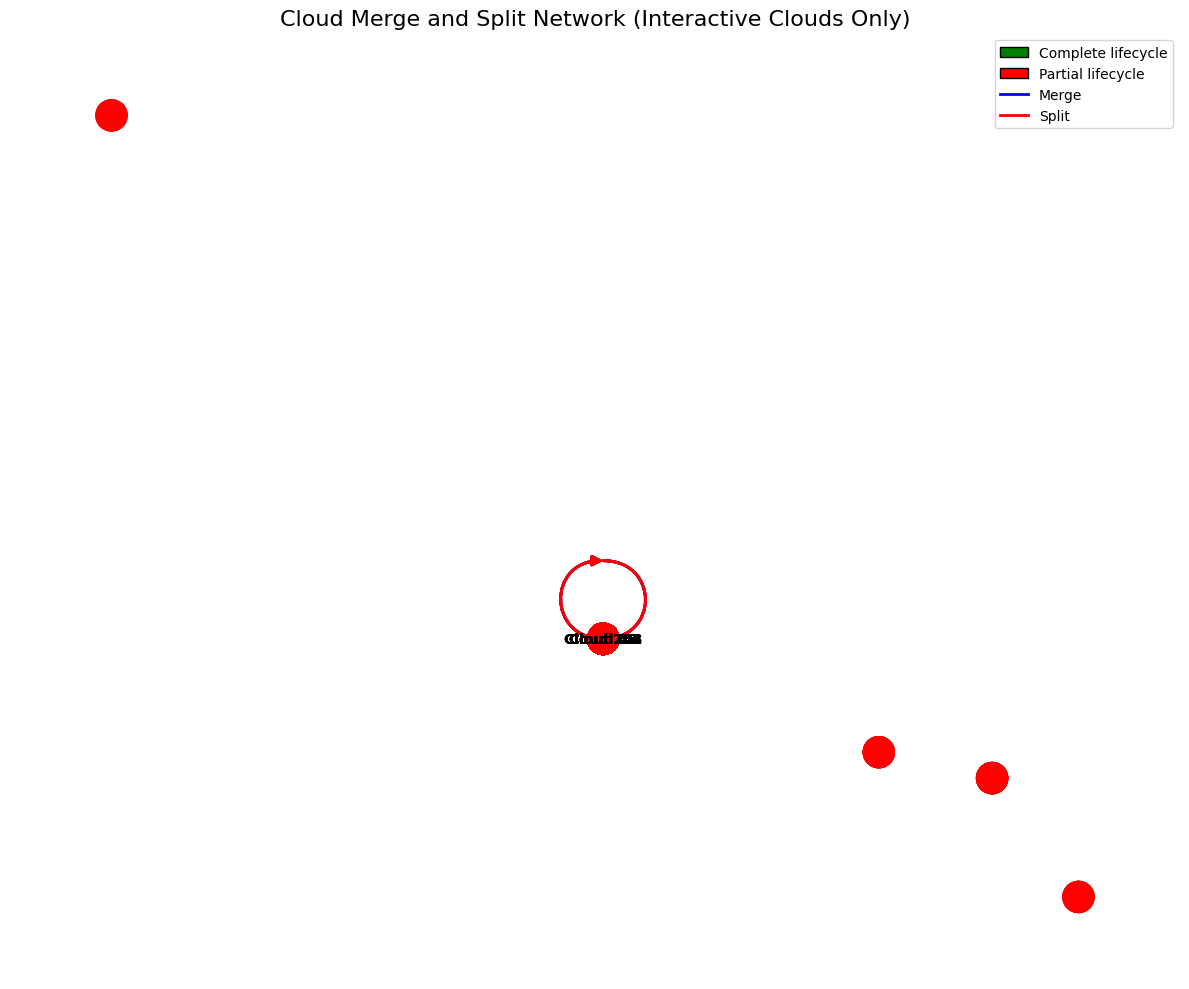

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
from netCDF4 import Dataset
import numpy as np

# Load your data
nc_file = '../cloud_results.nc'
dataset = Dataset(nc_file, 'r')

# Load necessary variables
merged_into = dataset.variables['merged_into'][:]
split_from = dataset.variables['split_from'][:]
track_id = dataset.variables['track_id'][:]
valid_tracks = dataset.variables['valid_track'][:]

# Filter for valid clouds (complete lifecycle)
full_lifecycle_indices = np.where(valid_tracks == 1)[0]
print(f"Found {len(full_lifecycle_indices)} clouds with complete lifecycles")

# First pass: identify clouds with merges/splits - improved approach
cloud_connections = {}
interactive_clouds = set()

# Count merges
for i in full_lifecycle_indices:
    node_id = int(track_id[i]) if not np.ma.is_masked(track_id[i]) else i
    merge_count = np.sum(merged_into[i, :] >= 0)
    split_count = np.sum(split_from[i, :] >= 0)
    
    # Store clouds that participate in merges or splits
    if merge_count > 0 or split_count > 0:
        interactive_clouds.add(i)
        cloud_connections[node_id] = merge_count + split_count

# Debug: Print out more detailed merge/split information
print(f"Found {len(interactive_clouds)} clouds with merges/splits")
if len(interactive_clouds) == 0:
    print("No clouds with merges or splits found. Cannot create network graph.")
else:
    print("Top 5 most interactive clouds:")
    sorted_connections = sorted(cloud_connections.items(), key=lambda x: x[1], reverse=True)
    for node_id, count in sorted_connections[:5]:
        print(f"  Cloud {node_id}: {count} interactions")

# If we have interactive clouds, proceed with graph creation
if len(interactive_clouds) > 0:
    # Limit the number of nodes for better performance
    MAX_NODES = 30  # Further reduced for better performance
    
    # If we have too many interactive clouds, select the most interesting ones
    selected_nodes = list(cloud_connections.keys())
    if len(selected_nodes) > MAX_NODES:
        sorted_connections = sorted(cloud_connections.items(), key=lambda x: x[1], reverse=True)
        selected_nodes = [node for node, _ in sorted_connections[:MAX_NODES]]
        print(f"Limiting visualization to {len(selected_nodes)} most connected clouds")

    # Get indices corresponding to selected node IDs
    selected_clouds = [i for i in full_lifecycle_indices if 
                      (int(track_id[i]) if not np.ma.is_masked(track_id[i]) else i) in selected_nodes]

    # Create a directed graph
    G = nx.DiGraph()

    # Track mapping of track_id to indices
    track_to_index = {}

    # Add nodes with valid tracks
    for i in selected_clouds:
        node_id = int(track_id[i]) if not np.ma.is_masked(track_id[i]) else i
        track_to_index[node_id] = i
        G.add_node(node_id, valid=True, label=f"Cloud {node_id}")

    # Add edges for merges
    merge_edge_count = 0
    for i in selected_clouds:
        source = int(track_id[i]) if not np.ma.is_masked(track_id[i]) else i
        
        # Find all timesteps with merges
        merge_timesteps = np.where(merged_into[i, :] >= 0)[0]
        
        for t in merge_timesteps:
            target = int(merged_into[i, t])
            # Add the target node if needed
            if target not in G:
                G.add_node(target, valid=(target in track_to_index), label=f"Cloud {target}")
            G.add_edge(source, target, edge_type='merge', timestep=t)
            merge_edge_count += 1
    
    # Add edges for splits
    split_edge_count = 0
    for i in selected_clouds:
        target = int(track_id[i]) if not np.ma.is_masked(track_id[i]) else i
        
        # Find all timesteps with splits
        split_timesteps = np.where(split_from[i, :] >= 0)[0]
        
        for t in split_timesteps:
            source = int(split_from[i, t])
            # Add the source node if needed
            if source not in G:
                G.add_node(source, valid=(source in track_to_index), label=f"Cloud {source}")
            G.add_edge(source, target, edge_type='split', timestep=t)
            split_edge_count += 1

    print(f"Added {merge_edge_count} merge edges and {split_edge_count} split edges")
    print(f"Network has {len(G.nodes())} nodes and {len(G.edges())} edges")

    # Check if graph is empty
    if len(G.nodes()) == 0 or len(G.edges()) == 0:
        print("ERROR: Graph has no nodes or edges. Cannot visualize.")
    else:
        # Create plot
        plt.figure(figsize=(12, 10))

        # Define node colors based on validity
        node_colors = ['green' if G.nodes[n].get('valid', False) else 'red' for n in G.nodes()]

        # Define edge colors based on type
        edge_colors = []
        for u, v, data in G.edges(data=True):
            if data['edge_type'] == 'merge':
                edge_colors.append('blue')
            else:  # split
                edge_colors.append('red')

        # Try different layout algorithms
        try:
            print("Calculating graph layout...")
            if len(G.nodes()) > 20:
                print("Using spectral_layout for better performance with large graphs...")
                pos = nx.spectral_layout(G)  # Often faster than kamada_kawai
            else:
                print("Using spring_layout for graph visualization...")
                pos = nx.spring_layout(G, seed=42, k=0.8)  # Increased k for more spacing
        except Exception as e:
            print(f"Error calculating layout: {e}")
            print("Falling back to shell layout...")
            pos = nx.shell_layout(G)  # Simpler fallback layout

        print("Drawing network graph...")
        # Draw the graph
        nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, alpha=0.8)
        
        # Draw edges with simpler style for better performance
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2, alpha=0.7,
                              arrowsize=15)

        # Only draw labels if there aren't too many nodes
        if len(G.nodes()) <= 20:
            nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
        else:
            # Draw labels only for the 10 most connected nodes
            top_connected = sorted(G.nodes(), key=lambda n: G.degree(n), reverse=True)[:10]
            labels = {n: G.nodes[n]['label'] for n in top_connected}
            nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_weight='bold')

        # Add a title
        plt.title("Cloud Merge and Split Network (Interactive Clouds Only)", fontsize=16)

        # Add a legend
        from matplotlib.patches import Patch
        from matplotlib.lines import Line2D
        legend_elements = [
            Patch(facecolor='green', edgecolor='black', label='Complete lifecycle'),
            Patch(facecolor='red', edgecolor='black', label='Partial lifecycle'),
            Line2D([0], [0], color='blue', lw=2, label='Merge'),
            Line2D([0], [0], color='red', lw=2, label='Split')
        ]
        plt.legend(handles=legend_elements, loc='upper right')

        plt.axis('off')  # Turn off axis
        plt.tight_layout()

        print("Rendering final plot...")
        plt.show()
else:
    print("No clouds with merges or splits to visualize.")
    # Create an empty plot with a message
    plt.figure(figsize=(10, 6))
    plt.text(0.5, 0.5, "No clouds with merges or splits found in dataset", 
             horizontalalignment='center', verticalalignment='center',
             fontsize=14)
    plt.axis('off')
    plt.show()

dataset.close()

Found 5 interesting cloud cases for case studies


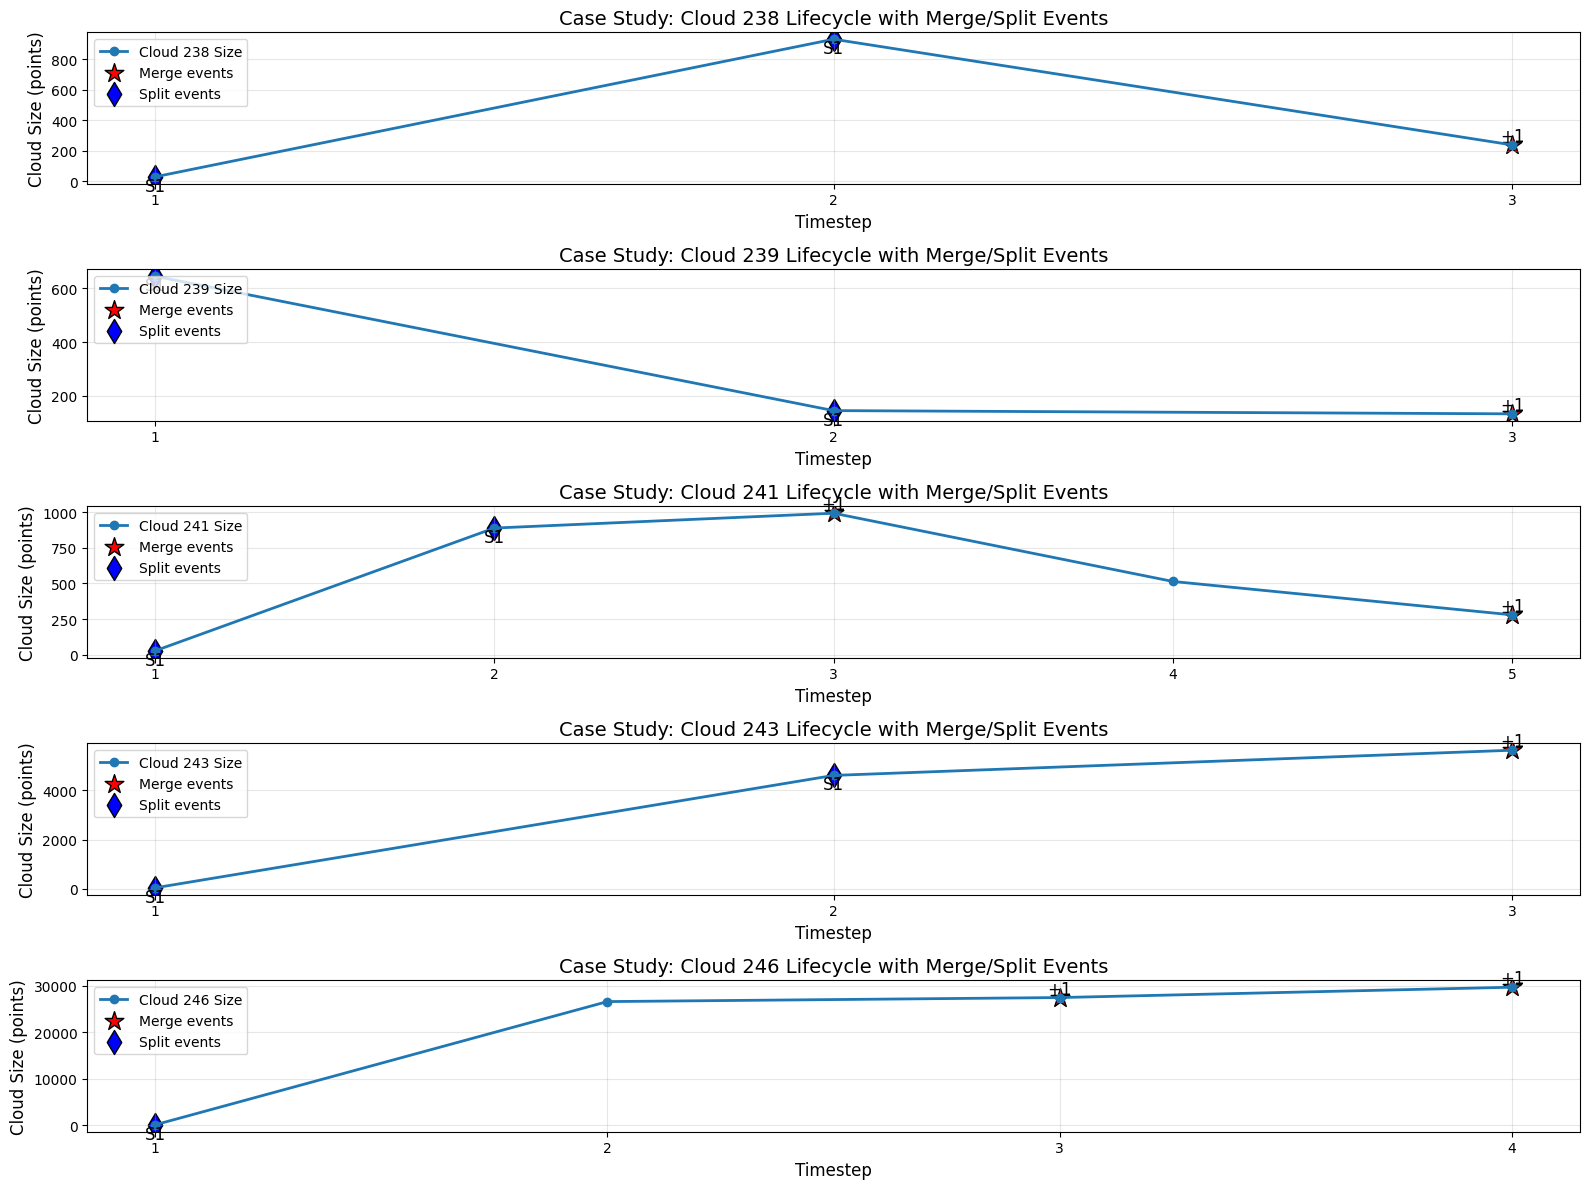

In [4]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np

# Load your data
nc_file = '../cloud_results.nc'
dataset = Dataset(nc_file, 'r')

# Function to find interesting merge/split events from valid clouds only
def find_interesting_events(merges_count, splits_count, x_centers, y_centers, valid_tracks):
    # Filter for valid clouds (complete lifecycle only)
    full_lifecycle_indices = np.where(valid_tracks == 1)[0]
    
    # Look for clouds involved in both merges and splits
    complex_clouds = []
    
    for i in full_lifecycle_indices:
        # Check if this cloud has both merges and splits
        if (np.nansum(merges_count[i,:]) > 0 and np.nansum(splits_count[i,:]) > 0):
            # Ensure the cloud has valid location data
            if np.any(~np.isnan(x_centers[i,:])):
                complex_clouds.append(i)
    
    # If no complex cases found, look for clouds with multiple merges
    if len(complex_clouds) == 0:
        for i in full_lifecycle_indices:
            if np.nansum(merges_count[i,:]) > 1:
                if np.any(~np.isnan(x_centers[i,:])):
                    complex_clouds.append(i)
    
    # If still no cases found, look for any cloud with at least one merge
    if len(complex_clouds) == 0:
        for i in full_lifecycle_indices:
            if np.nansum(merges_count[i,:]) > 0:
                if np.any(~np.isnan(x_centers[i,:])):
                    complex_clouds.append(i)
    
    return complex_clouds[:5]  # Return up to 5 interesting cases

# Load necessary variables
merges_count = dataset.variables['merges_count'][:]
splits_count = dataset.variables['splits_count'][:]
x_centers = dataset.variables['location_x'][:]
y_centers = dataset.variables['location_y'][:]
merged_into = dataset.variables['merged_into'][:]
split_from = dataset.variables['split_from'][:]
size_var = dataset.variables['size'][:]  # Cloud size
valid_tracks = dataset.variables['valid_track'][:]  # Add valid tracks filter

# Find some interesting cases (only from valid clouds)
interesting_clouds = find_interesting_events(merges_count, splits_count, 
                                           x_centers, y_centers, valid_tracks)

print(f"Found {len(interesting_clouds)} interesting cloud cases for case studies")

# Case study visualization
plt.figure(figsize=(16, 12))

for i, cloud_idx in enumerate(interesting_clouds):
    plt.subplot(len(interesting_clouds), 1, i+1)
    
    # Get valid timesteps for this cloud
    valid_idx = ~np.isnan(x_centers[cloud_idx, :])
    timesteps = np.where(valid_idx)[0]
    
    if len(timesteps) == 0:
        continue
    
    # Plot cloud size over time
    plt.plot(timesteps, size_var[cloud_idx, timesteps], 'o-', linewidth=2, 
             label=f'Cloud {cloud_idx} Size')
    
    # Mark merge events
    merge_timesteps = np.where(valid_idx & (merges_count[cloud_idx, :] > 0))[0]
    if len(merge_timesteps) > 0:
        plt.scatter(merge_timesteps, size_var[cloud_idx, merge_timesteps], 
                   marker='*', s=200, color='red', edgecolor='black', 
                   label='Merge events')
        
        # Add merge count labels
        for ts in merge_timesteps:
            plt.text(ts, size_var[cloud_idx, ts], f"+{int(merges_count[cloud_idx, ts])}", 
                    fontsize=12, ha='center', va='bottom')
    
    # Mark split events
    split_timesteps = np.where(valid_idx & (splits_count[cloud_idx, :] > 0))[0]
    if len(split_timesteps) > 0:
        plt.scatter(split_timesteps, size_var[cloud_idx, split_timesteps], 
                   marker='d', s=150, color='blue', edgecolor='black', 
                   label='Split events')
        
        # Add split labels
        for ts in split_timesteps:
            plt.text(ts, size_var[cloud_idx, ts], f"S{int(splits_count[cloud_idx, ts])}", 
                    fontsize=12, ha='center', va='top')
    
    plt.title(f'Case Study: Cloud {cloud_idx} Lifecycle with Merge/Split Events', fontsize=14)
    plt.xlabel('Timestep', fontsize=12)
    plt.ylabel('Cloud Size (points)', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(timesteps)

plt.tight_layout()
plt.show()

dataset.close()

# Animate 2d slices


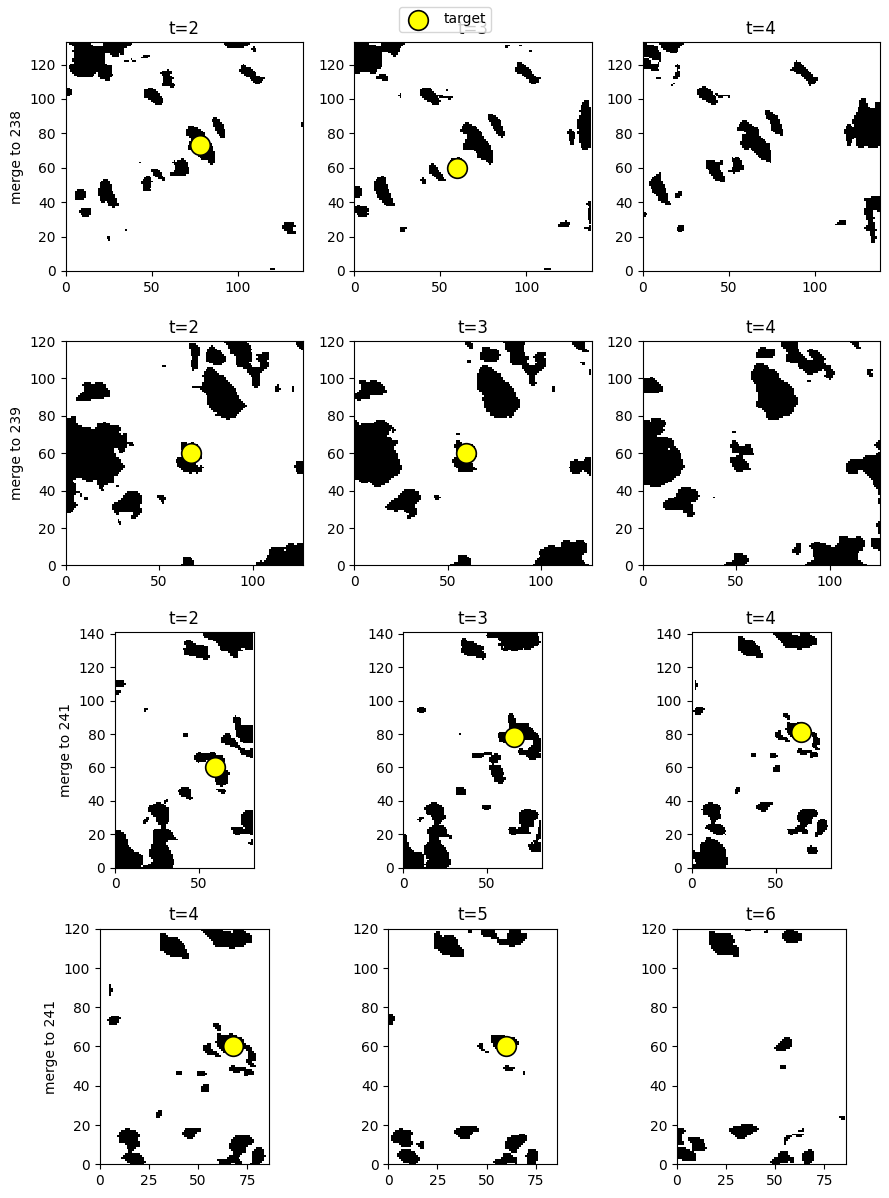

Merges check done. Mismatches: 800, parent edges to invalid targets: 0
  t=2 target_idx=238: expected=1 parents, merges_count=0
  t=2 target_idx=239: expected=1 parents, merges_count=0
  t=2 target_idx=241: expected=2 parents, merges_count=0
  t=2 target_idx=243: expected=3 parents, merges_count=0
  t=2 target_idx=246: expected=2 parents, merges_count=0
  t=2 target_idx=248: expected=2 parents, merges_count=0
  t=2 target_idx=249: expected=1 parents, merges_count=0
  t=2 target_idx=254: expected=5 parents, merges_count=0
  t=2 target_idx=255: expected=1 parents, merges_count=0
  t=2 target_idx=261: expected=1 parents, merges_count=0
Derived splits_count_B built (parent@t, children-1).


In [5]:
# Utilities + static multi-event merge panels with correct meter→index mapping
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

BASE = '/Users/jure/PhD/coding/RICO_1hr/'
LFILE = 'rico.l.nc'
LVAR = 'l'
L_THR = 1e-6
PAD = 60

def get_grid_meta(base=BASE, fname=LFILE, var=LVAR):
    with Dataset(base + fname) as nc:
        lvar = nc.variables[var]
        ny, nx = lvar.shape[-2], lvar.shape[-1]
        # coords
        xcoord = None; ycoord = None
        for xn in ('xt', 'x'):
            if xn in nc.variables:
                xcoord = np.asarray(nc.variables[xn][:], dtype=float)
                break
        for yn in ('yt', 'y'):
            if yn in nc.variables:
                ycoord = np.asarray(nc.variables[yn][:], dtype=float)
                break
        # fallbacks
        if xcoord is None: xcoord = np.arange(nx, dtype=float)
        if ycoord is None: ycoord = np.arange(ny, dtype=float)
        dx = float(np.nanmean(np.diff(xcoord))) if xcoord.size > 1 else 1.0
        dy = float(np.nanmean(np.diff(ycoord))) if ycoord.size > 1 else 1.0
        x0 = float(xcoord[0]) if xcoord.size else 0.0
        y0 = float(ycoord[0]) if ycoord.size else 0.0
    return {'nx': nx, 'ny': ny, 'dx': dx, 'dy': dy, 'x0': x0, 'y0': y0,
            'xcoord': xcoord, 'ycoord': ycoord}

def wrap_to_domain(x, x0, w):
    # Map meters x into [x0, x0+w)
    return (x - x0) % w + x0

def meters_to_idx(x, y, meta):
    # subtract origin, divide by spacing, wrap to domain size
    W = meta['nx'] * meta['dx']; H = meta['ny'] * meta['dy']
    xw = wrap_to_domain(float(x), meta['x0'], W)
    yw = wrap_to_domain(float(y), meta['y0'], H)
    ix = int(np.clip(np.floor((xw - meta['x0']) / meta['dx']), 0, meta['nx'] - 1))
    iy = int(np.clip(np.floor((yw - meta['y0']) / meta['dy']), 0, meta['ny'] - 1))
    return ix, iy

def load_mask(frame, meta, base=BASE, fname=LFILE, var=LVAR, thr=L_THR):
    with Dataset(base + fname) as nc:
        L = np.asarray(nc.variables[var][frame, ...])  # (z,y,x)
        mask = (L > thr).any(axis=0)                   # (y,x)
    return mask

# Load tracking data once
with Dataset('../cloud_results.nc') as ds:
    valid = np.asarray(ds.variables['valid_track'][:], dtype=bool)
    xC = np.asarray(np.ma.filled(ds.variables['location_x'][:], np.nan), dtype=float)
    yC = np.asarray(np.ma.filled(ds.variables['location_y'][:], np.nan), dtype=float)
    merges_count = np.asarray(np.ma.filled(ds.variables['merges_count'][:], 0), dtype=int)
    merged_into = np.asarray(np.ma.filled(ds.variables['merged_into'][:], -1), dtype=int)

meta = get_grid_meta()

# Pick K merge targets and draw t-1,t,t+1 panels
events = np.argwhere((merges_count > 0) & valid[:, None])
K = min(4, len(events))
if K == 0:
    print("No merge events to plot.")
else:
    fig, axes = plt.subplots(K, 3, figsize=(9, 3*K), squeeze=False)
    for r in range(K):
        tgt, t = map(int, events[r])
        parents = np.where(merged_into[:, t] == tgt)[0]
        parents = parents[valid[parents]]
        frames = [tt for tt in (t-1, t, t+1) if 0 <= tt < xC.shape[1]]

        # Build bbox in index space from all participants across frames
        xs = []; ys = []
        for pid in list(parents) + [tgt]:
            for tt in frames:
                x, y = xC[pid, tt], yC[pid, tt]
                if np.isfinite(x) and np.isfinite(y):
                    ix, iy = meters_to_idx(x, y, meta)
                    xs.append(ix); ys.append(iy)

        if xs and ys:
            xmin = max(min(xs) - PAD, 0); xmax = min(max(xs) + PAD, meta['nx'])
            ymin = max(min(ys) - PAD, 0); ymax = min(max(ys) + PAD, meta['ny'])
        else:
            xmin, ymin, xmax, ymax = 0, 0, meta['nx'], meta['ny']

        for c, tt in enumerate(frames):
            ax = axes[r, c]
            mask = load_mask(tt, meta)
            view = mask[int(ymin):int(ymax), int(xmin):int(xmax)]
            ax.imshow(view, origin='lower', cmap='gray_r', interpolation='nearest')
            ax.set_xlim(0, view.shape[1]); ax.set_ylim(0, view.shape[0])

            # Parents (red, filled so they are visible)
            for pid in parents:
                x, y = xC[pid, tt], yC[pid, tt]
                if np.isfinite(x) and np.isfinite(y):
                    ix, iy = meters_to_idx(x, y, meta)
                    ax.scatter(ix - int(xmin), iy - int(ymin), s=160,
                               facecolors='red', edgecolors='black', linewidths=0.8,
                               zorder=3, label='parent' if c == 0 else None)

            # Target (yellow)
            x, y = xC[tgt, tt], yC[tgt, tt]
            if np.isfinite(x) and np.isfinite(y):
                ix, iy = meters_to_idx(x, y, meta)
                ax.scatter(ix - int(xmin), iy - int(ymin), s=200,
                           facecolors='yellow', edgecolors='black', linewidths=1.2,
                           zorder=4, label='target' if c == 0 else None)

            ax.set_title(f"t={tt}")
            if c == 0:
                ax.set_ylabel(f"merge to {tgt}")

        handles, labels = axes[r, 0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='upper center', ncol=2)
    fig.tight_layout()
    plt.show()




# 2) Check merges_count consistency with merged_into pointers (use indices directly)
import numpy as np
from netCDF4 import Dataset

with Dataset('../cloud_results.nc') as ds:
    valid = np.asarray(ds.variables['valid_track'][:], dtype=bool)
    merged_into = np.asarray(np.ma.filled(ds.variables['merged_into'][:], -1), dtype=int)  # indices
    merges_count = np.asarray(np.ma.filled(ds.variables['merges_count'][:], 0), dtype=int)

    T = merged_into.shape[1]
    mismatches = []
    missing_targets = 0

    for t in range(T):
        parents = np.where(valid)[0]
        tgt_idx = merged_into[parents, t]
        tgt_idx = tgt_idx[tgt_idx >= 0]  # already indices
        if tgt_idx.size == 0:
            continue
        unique_idx, counts = np.unique(tgt_idx, return_counts=True)
        for idx, cnt in zip(unique_idx, counts):
            if idx < 0 or idx >= valid.shape[0]:
                missing_targets += cnt
                continue
            expected = cnt
            got = int(merges_count[idx, t])
            if expected != got:
                mismatches.append((int(t), int(idx), expected, got))

    print(f"Merges check done. Mismatches: {len(mismatches)}, parent edges to invalid targets: {missing_targets}")
    for rec in mismatches[:10]:
        t, idx, expct, got = rec
        print(f"  t={t} target_idx={idx}: expected={expct} parents, merges_count={got}")










# Derive splits_count_B from split_from (parent@t, children-1)
import numpy as np
from netCDF4 import Dataset

with Dataset('../cloud_results.nc') as ds:
    valid = np.asarray(ds.variables['valid_track'][:], dtype=bool)
    split_from = np.asarray(np.ma.filled(ds.variables['split_from'][:], -1), dtype=int)
    T = split_from.shape[1]
    n_tracks = split_from.shape[0]

# children per (parent,t)
child_idx, t_child = np.where((split_from >= 0) & valid[:, None])
parent_idx = split_from[child_idx, t_child].astype(int)
good = (parent_idx >= 0) & (parent_idx < n_tracks)
parent_idx = parent_idx[good]; t_child = t_child[good]

derived_splits = np.zeros((n_tracks, T), dtype=int)
# ToDo (optimisation): could use sparse add; array is small here
keys, counts = np.unique(parent_idx * T + t_child, return_counts=True)
for key, cnt in zip(keys, counts):
    p = int(key // T); t = int(key % T)
    derived_splits[p, t] = max(int(cnt) - 1, 0)

print("Derived splits_count_B built (parent@t, children-1).")

# You can now use derived_splits instead of ds.variables['splits_count'] for plots